In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Using leavitts Law to find constants:
  $$M = a \cdot \log_{10}{P} + b$$

Constant a: -0.9625746586138317
Constant b: -1.6808674146142548


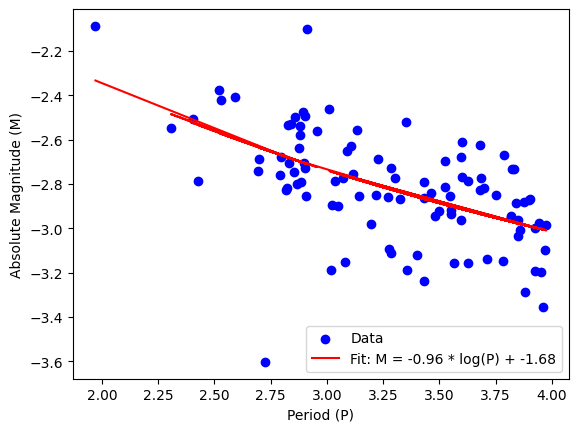

In [3]:
data = pd.read_csv(r"cepheids.csv") 

P = data['Period'].values  # period
M = data['M'].values  #absolute_mag

logP = np.log(P)

# converting to 2d array
logP = logP.reshape(-1, 1)
M = M.reshape(-1, 1)

# use multilinear regression to find the best fit 
model = LinearRegression()
model.fit(logP, M)

a = model.coef_[0][0]  # Slope_a
b = model.intercept_[0]  # Intercept_b

print(f"Constant a: {a}")
print(f"Constant b: {b}")

# scatterplot and best fit visualisation.
plt.scatter(P, M, color='blue', label='Data')
plt.plot(P, model.predict(logP), color='red', label=f'Fit: M = {a:.2f} * log(P) + {b:.2f}')
plt.xlabel('Period (P)')
plt.ylabel('Absolute Magnitude (M)')
plt.legend()
plt.show()

# Plotting the data along with the fitted line to visually verify the correct constants.

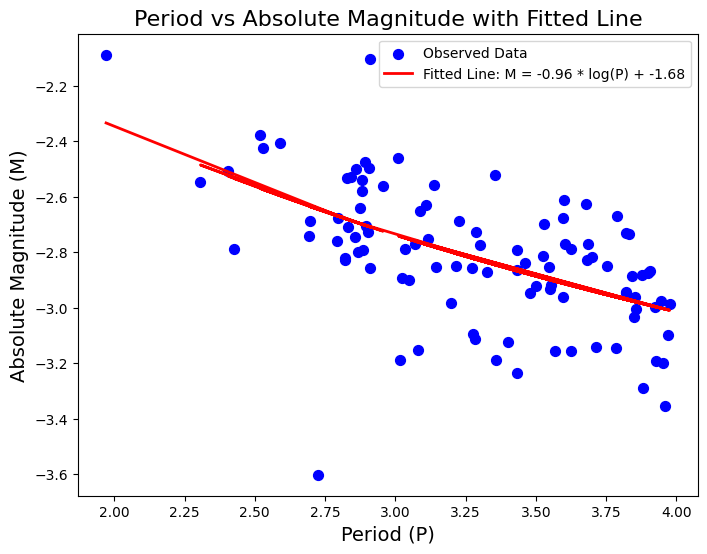

In [4]:
# calculate absolute_mag using the a and b
M_pred = a * np.log(P) + b

#plotting
plt.figure(figsize=(8, 6))

# Scatter plot of given data
plt.scatter(P, M, color="blue", label="Observed Data", s=50)

# plotting fitted line with calculated magnitude values
plt.plot(P, M_pred, color="red", label=f"Fitted Line: M = {a:.2f} * log(P) + {b:.2f}", linewidth=2)
plt.xlabel("Period (P)", fontsize=14)
plt.ylabel("Absolute Magnitude (M)", fontsize=14)
plt.title("Period vs Absolute Magnitude with Fitted Line", fontsize=16)
plt.legend()
plt.show()

# Findin period of each cepheid

In [4]:
# since we dont know the distance,we use the light curve and fit with a sinosoidal wave to find peaks 
# and use it to find the frequency and hence the period

# sinusoidal model for the light curve
def light_curve_model(t, A, f, phi, C):
    return A * np.sin(2 * np.pi * f * t + phi) + C

data = pd.read_csv(r"curves.csv") 
periods = []

unique_ids = data['ID'].unique()

# Looping to calculate for each ID
for cepheid_id in unique_ids:
    # data for the current Cepheid ID
    cepheid_data = data[data['ID'] == cepheid_id]
    
    # getting time (JD) and apparent magnitude data
    time = cepheid_data['JD']
    magnitude = cepheid_data['m']
    
    # Initial guess for the fit parameters (Amplitude, Frequency, Phase, Offset)
    initial_guess = [np.max(magnitude) - np.min(magnitude), 1/10, 0, np.mean(magnitude)]
    
    # Fitting the model to the data using curve fitting
    try:
        params, covariance = curve_fit(light_curve_model, time, magnitude, p0=initial_guess)
        
        # getting the fitted parameters
        A, f, phi, C = params
        
        # Calculating period from frequency
        P = 1 / f
        
        # Save the Cepheid ID and its estimated period
        periods.append([cepheid_id, P])
        
        # plotting the light curve and the fitted curve
        plt.figure(figsize=(10, 6))
        plt.scatter(time, magnitude, label=f'Cepheid ID {cepheid_id} Data', color='blue', s=10)
        plt.plot(time, light_curve_model(time, *params), label=f'Fitted Curve (Period={P:.2f} days)', color='red', lw=2)
        plt.gca().invert_yaxis()  # Invert y-axis for apparent magnitude
        plt.xlabel('Julian Date (JD)')
        plt.ylabel('Apparent Magnitude')
        plt.title(f'Cepheid Light Curve (ID: {cepheid_id})')
        plt.legend()
        plt.show()

    except Exception as e:
        print(f"Could not fit Cepheid ID {cepheid_id}: {e}")

# Convert the results to a DataFrame
periods_df = pd.DataFrame(periods, columns=['ID', 'Period'])

# Save the periods to a new CSV file
periods_df.to_csv('calculated_periods.csv', index=False)

# Display the results
print(periods_df)
        


          ID     Period
0    2434670  10.003895
1    2442608  10.061030
2    2443943  10.059022
3    2446727   9.874483
4    2447157   9.924107
..       ...        ...
970   832653   9.998995
971  2190690  10.089528
972   566046   9.980167
973   188335  10.016812
974  1614138  10.020875

[975 rows x 2 columns]


# Using the calculated periods to find the absolute magnitude of these stars using the relation found earlier

In [7]:
periods_df = pd.read_csv(r"calculated_periods.csv")  

# a and b,already found
a = -0.9625746586138317 
b = -1.6808674146142548  

# Leavitts law
def calculate_absolute_magnitude(P, a, b):
    return a * np.log10(P) + b

# Calculating the absolute_mag for each Cepheid
periods_df['Absolute_Magnitude'] = periods_df['Period'].apply(calculate_absolute_magnitude, args=(a, b))

# Save the results to a new CSV file
periods_df.to_csv('calculated_absolute_magnitudes.csv', index=False)

# Display the results
print(periods_df[['ID', 'Period', 'Absolute_Magnitude']])

          ID     Period  Absolute_Magnitude
0    2434670  10.003895           -2.643605
1    2442608  10.061030           -2.645986
2    2443943  10.059022           -2.645902
3    2446727   9.874483           -2.638162
4    2447157   9.924107           -2.640257
..       ...        ...                 ...
970   832653   9.998995           -2.643400
971  2190690  10.089528           -2.647168
972   566046   9.980167           -2.642612
973   188335  10.016812           -2.644144
974  1614138  10.020875           -2.644314

[975 rows x 3 columns]


# Using the apparent magnitude data finding the distance to these cepheid variables

In [8]:
# Now that we have both apparent and absolute magnitude, we use
# M=m-5.(log(d)-1), to get the distance

periods_df = pd.read_csv(r"calculated_absolute_magnitudes.csv") 
data = pd.read_csv(r"curves.csv") 

# Merge the two dataframes based on Cepheid ID to get the apparent magnitudes and absolute magnitudes together
merged_df = pd.merge(data, periods_df[['ID', 'Absolute_Magnitude']], on='ID')

# Reaaranging the formula to get diatance
def calculate_distance(m, M):
    return 10 * 10**((m - M + 5) / 5)

# Calculate the distance for each Cepheid
merged_df['Distance'] = merged_df.apply(lambda row: calculate_distance(row['m'], row['Absolute_Magnitude']), axis=1)

# Save the results to a new CSV file
merged_df.to_csv('calculated_distances.csv', index=False)

# Display the results
print(merged_df[['ID', 'm', 'Absolute_Magnitude', 'Distance']])

             ID          m  Absolute_Magnitude      Distance
0       2434670  22.255868           -2.643605  9.547608e+06
1       2434670  21.972137           -2.643605  8.378155e+06
2       2434670  21.980222           -2.643605  8.409407e+06
3       2434670  22.179343           -2.643605  9.217000e+06
4       2434670  22.060510           -2.643605  8.726156e+06
...         ...        ...                 ...           ...
291745  1614138  18.581137           -2.644314  1.758289e+06
291746  1614138  18.652272           -2.644314  1.816842e+06
291747  1614138  18.648829           -2.644314  1.813964e+06
291748  1614138  18.679052           -2.644314  1.839387e+06
291749  1614138  18.673592           -2.644314  1.834768e+06

[291750 rows x 4 columns]


# The distance to the galaxy being observed

In [9]:
# the average distance will do the job as the cepheids in the galaxy are relatively close,
# so the average distance off all them togather should give the distance to the galaxy

merged_df = pd.read_csv(r"calculated_distances.csv")  

# Average diastance to the galaxy
average_distance = merged_df['Distance'].mean()

# Display the average distance to the galaxy
print(f'Average Distance to the Galaxy: {average_distance} parsecs')

Average Distance to the Galaxy: 5209620.561103584 parsecs
